In [2130]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jax.numpy.linalg import norm

from typing import Optional

In [2131]:
data = pd.read_csv('/Users/liibanmohamud/Desktop/scikit-jax/examples/data/clustering_data/basic5.csv')

In [2132]:
data.head()

,x,y,color
0,472.431845,133.637138,1
1,392.213650,248.151058,1
2,185.231588,128.911761,0
3,175.553180,234.373421,0
4,199.902134,373.492265,2


In [2133]:
M= jnp.array([[1,2],
              [4,5],
              [7,8]])

v = jnp.array([1,0])

#print(M-v)
1 / norm(M-v, axis=1)**2

u = jnp.array([1,2,3,4,5,6])

u / u.sum()

Array([0.04761905, 0.0952381 , 0.14285715, 0.1904762 , 0.23809524,
       0.2857143 ], dtype=float32)

In [2134]:
X = data.drop(columns='color').to_numpy(jnp.float32)
y = data['color'].to_numpy(jnp.float32)

X.shape, y.shape

((4000, 2), (4000,))

In [2135]:
def initialize_centroids(X:jax.Array, num_clusters:int, random_state:int=12):
    # k-means++ initialisation

    assert num_clusters > 0, f'num_clusters should be a natural number greater than 0. Instead got {num_clusters}'

    X_without_centroids = X.copy()

    key = jax.random.PRNGKey(random_state)
    init_index = jax.random.choice(key, X.shape[0])

    initialised_centroids = {}

    init_centroid = X[init_index]
    initialised_centroids[0] = init_centroid

    squared_distances_from_init_centroid = jnp.zeros(X_without_centroids.shape[0])

    if num_clusters == 1:
        return init_centroid
    else:
        for cluster in range(1, num_clusters):
            X_without_centroids = jnp.vstack([X_without_centroids[:init_index], X_without_centroids[init_index+1:]])
            squared_distances_from_init_centroid = norm(X_without_centroids - init_centroid, axis=1)**2
            prob_dist_of_centroid_chosen = squared_distances_from_init_centroid / squared_distances_from_init_centroid.sum()
            key, subkey = jax.random.split(key)
            init_index = jax.random.choice(subkey, X_without_centroids.shape[0], p=prob_dist_of_centroid_chosen)
            init_centroid = X_without_centroids[init_index]
            initialised_centroids[cluster] = init_centroid
    return initialised_centroids

In [2136]:
init_centroids = initialize_centroids(X, 3)
init_centroids

{0: array([232.48724, 365.3647 ], dtype=float32),
 1: Array([155.26581,  91.14223], dtype=float32),
 2: Array([378.11423, 254.59435], dtype=float32)}

In [2137]:
def assign_clusters_to_data(X:jax.Array, centroids:dict):

    distances_matrix = jnp.zeros(shape=(len(centroids), X.shape[0]))

    for cluster, centroid in centroids.items():
        distances_from_cluster = norm(X - centroid, axis=1)
        distances_matrix = distances_matrix.at[cluster].set(distances_from_cluster)
    
    assigned_clusters = distances_matrix.argmin(axis=0)

    return assigned_clusters

In [2138]:
assigned_centroids = assign_clusters_to_data(X, init_centroids)

In [2139]:
def calculate_new_centroids(X:jax.Array, assigned_centroids:jax.Array, num_clusters:int):
    
    centroids = {cluster: None for cluster in range(num_clusters)}
    new_distances = jnp.zeros(shape=(num_clusters, X.shape[0]))

    for cluster in range(num_clusters):
        indices_for_cluster = jnp.where(assigned_centroids==cluster)[0]
        X_at_cluster = X[indices_for_cluster]
        new_centroid = jnp.mean(X_at_cluster, axis=0)
        centroids[cluster] = new_centroid
        new_distances_for_cluster = norm(X - new_centroid, axis=1)
        new_distances = new_distances.at[cluster].set(new_distances_for_cluster)
        
    updated_centroids_for_X = new_distances.argmin(axis=0)
    return centroids, updated_centroids_for_X

In [2140]:
centroids, updated_centroids_for_X = calculate_new_centroids(X, assigned_centroids, 3)
centroids

{0: Array([274.35596, 362.11438], dtype=float32),
 1: Array([183.29001, 162.20284], dtype=float32),
 2: Array([429.6664 , 187.60489], dtype=float32)}

In [2141]:
num_clusters = 3
epochs = 200

def fit(X:jax.Array):
    initialised_centroids = initialize_centroids(X, num_clusters=num_clusters)

    centroids_for_each_data_point = assign_clusters_to_data(X, initialised_centroids)

    for epoch in range(5):
        centroids, centroids_for_each_data_point = calculate_new_centroids(X, centroids_for_each_data_point, 3)

    best_centroids = jnp.asarray(list(centroids.values()))
    
    return best_centroids

In [2142]:
best_centroids = fit(X)

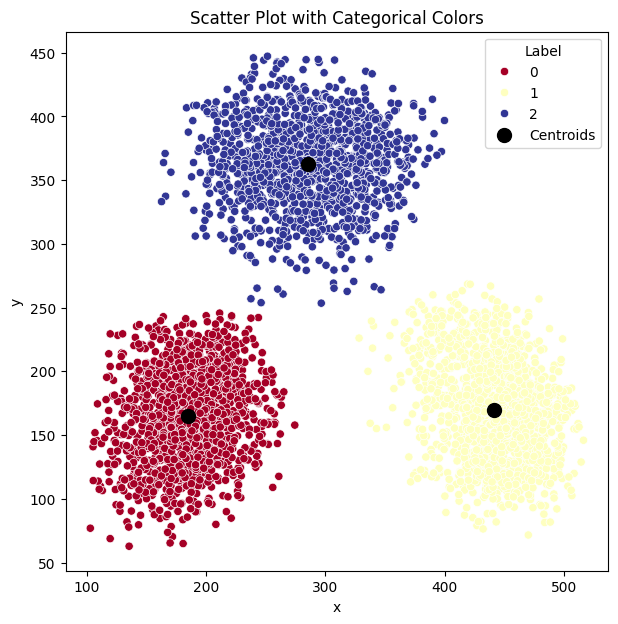

In [2143]:
plt.figure(figsize=(7,7))
palette = sns.color_palette('RdYlBu', as_cmap=True)

sns.scatterplot(data=data, x='x', y='y', hue='color', palette=palette, legend='full')
plt.scatter(best_centroids.T[0], best_centroids.T[1], color='black', s=100, label='Centroids')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot with Categorical Colors')
plt.legend(title='Label')

plt.show()

In [2144]:
data2 = pd.DataFrame({
    'x': [1, 2, 3, 8, 9, 7],
    'y': [2, 3, 3, 8, 9, 8],
    'cluster': [0, 0, 0, 1, 1, 1],
})

data2.head()

,x,y,cluster
0,1,2,0
1,2,3,0
2,3,3,0
3,8,8,1
4,9,9,1


In [2145]:
class MyKMeans:
    def __init__(
        self,
        num_clusters: int,
        epochs: int = 5,
        random_state: int = 5,
    ):
        """
        Initialize the KMeans clustering algorithm.

        Args:
            num_clusters (int): The number of clusters to form.
            epochs (int, optional): The number of iterations to run. Default is 25.
            init (str, optional): Method for initializing centroids ('random' or other methods). Default is 'random'.
            max_patience (int, optional): The maximum number of epochs to wait for improvement before stopping early. Default is 5.
            seed (int, optional): Random seed for reproducibility. Default is 12.
        """
        self.num_clusters: int = num_clusters
        self.epochs: int = epochs
        self.random_state: int = random_state

    def fit(self, X: jax.Array) -> None:
        """
        Compute the KMeans clustering.

        Args:
            X (jax.Array): Input data, where each row is a data point.

        Returns:
            self: The instance of the KMeans object with fitted centroids.
        """
        self.init_centroids = initialize_centroids(
            X, num_clusters=self.num_clusters
        )

        centroids_for_each_data_point = assign_clusters_to_data(X, self.init_centroids)

        for epoch in range(self.epochs):
            centroids, centroids_for_each_data_point = calculate_new_centroids(
                X, centroids_for_each_data_point, self.num_clusters
            )

        self.centroids = jnp.asarray(list(centroids.values()))

        return self

### DATA 2: Two distinct clusters

In [2146]:
X = data2.drop(columns='cluster').to_numpy(jnp.float32)
y = data2['cluster'].to_numpy(jnp.float32)

In [2147]:
model = MyKMeans(2)
model_fitted = model.fit(X)
model_fitted.centroids

Array([[2.       , 2.6666667],
       [8.       , 8.333334 ]], dtype=float32)

In [2148]:
from sklearn.cluster import KMeans

model_sk_fitted = KMeans(2).fit(X)
model_sk_fitted.cluster_centers_

array([[2.       , 2.6666665],
       [8.       , 8.333334 ]], dtype=float32)

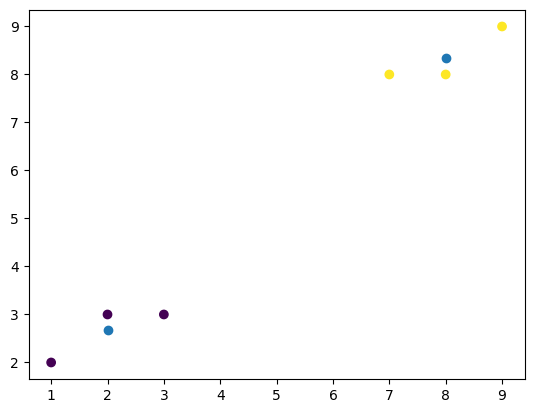

In [2149]:
best_centroids = model_fitted.centroids

plt.scatter(data2['x'], data2['y'], c=data2['cluster'])
plt.scatter(best_centroids.T[0], best_centroids.T[1])

### DATA 3: Three Clusters with Overlap

In [2150]:
data3 = pd.DataFrame({
    'x': [1, 2, 3, 5, 6, 5, 9, 8, 10],
    'y': [1, 1, 2, 5, 5, 6, 9, 8, 10],
    'cluster': [1, 1, 1, 2, 2, 2, 3, 3, 3]
})

data3.head()

,x,y,cluster
0,1,1,1
1,2,1,1
2,3,2,1
3,5,5,2
4,6,5,2


In [2151]:
X = data3.drop(columns='cluster').to_numpy(jnp.float32)
y = data3['cluster'].to_numpy(jnp.float32)

In [2152]:
model = MyKMeans(3)
model_fitted = model.fit(X)
model_fitted.centroids

/Users/liibanmohamud/Desktop/scikit-jax/.venv/lib/python3.11/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Array([[9.       , 9.       ],
       [2.       , 1.3333334],
       [5.3333335, 5.3333335]], dtype=float32)

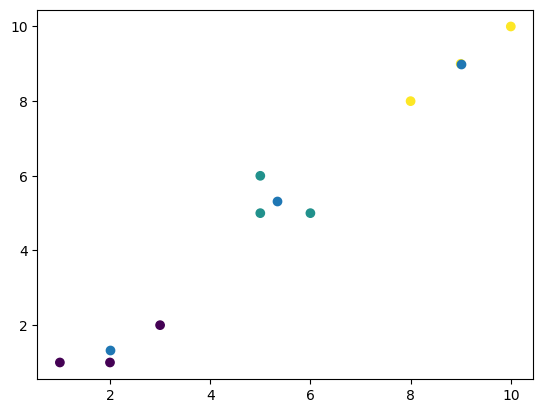

In [2153]:
best_centroids = model_fitted.centroids

plt.scatter(data3['x'], data3['y'], c=data3['cluster'])
plt.scatter(best_centroids.T[0], best_centroids.T[1])

### DATA 4: Four Well-Separated Clusters

In [2154]:
data4 = pd.DataFrame({
    'x': [0, 1, 10, 11, 0, 1, 10, 11],
    'y': [0, 1, 0, 1, 10, 11, 10, 11],
    'cluster': [1, 1, 2, 2, 3, 3, 4, 4]
})

data4.head()

,x,y,cluster
0,0,0,1
1,1,1,1
2,10,0,2
3,11,1,2
4,0,10,3


In [2155]:
X = data4.drop(columns='cluster').to_numpy(jnp.float32)
y = data4['cluster'].to_numpy(jnp.float32)

In [2156]:
model = MyKMeans(4, epochs=5)
model_fitted = model.fit(X)
model_fitted.centroids

Array([[ 0.5,  0.5],
       [10.5,  0.5],
       [ 0.5, 10.5],
       [10.5, 10.5]], dtype=float32)

In [2157]:
KMeans(4).fit(X).cluster_centers_

array([[ 0.5, 10.5],
       [10.5,  0.5],
       [ 0.5,  0.5],
       [10.5, 10.5]], dtype=float32)

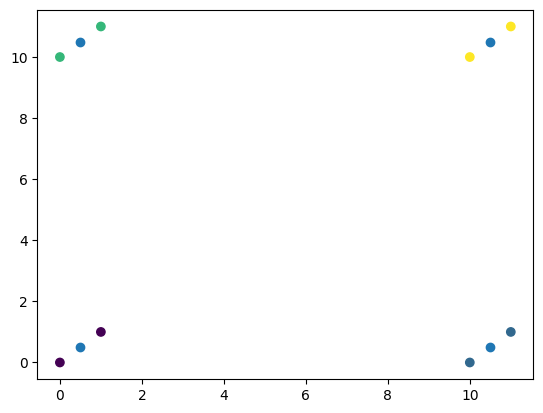

In [2158]:
best_centroids = model_fitted.centroids

plt.scatter(data4['x'], data4['y'], c=data4['cluster'])
plt.scatter(best_centroids.T[0], best_centroids.T[1])

### DATA 5: Unittest 1

In [2159]:
X1 = jnp.array([
    [1, 2], [1, 3], [2, 2], [2, 3],  # Cluster 1
    [8, 9], [8, 8], [9, 9], [9, 8]   # Cluster 2
])

In [2160]:
model = MyKMeans(num_clusters=2)
model_fitted = model.fit(X1)
model.centroids.sort(axis=0)

Array([[1.5, 2.5],
       [8.5, 8.5]], dtype=float32)

In [2161]:
X2 = jnp.array([
    [1, 1], [1, 2], [2, 1], [2, 2],  # Cluster 1
    [5, 5], [5, 6], [6, 5], [6, 6],  # Cluster 2
    [8, 1], [8, 2], [9, 1], [9, 2]   # Cluster 3
])

In [2162]:
model = MyKMeans(num_clusters=3)
model_fitted = model.fit(X2)
model_fitted.centroids 

Array([[8.5, 1.5],
       [1.5, 1.5],
       [5.5, 5.5]], dtype=float32)

In [2163]:
X3 = jnp.array([
    [1, 1], [1, 2], [2, 1],  # Cluster 1
    [5, 5], [5, 6], [6, 5], [6, 6],  # Cluster 2
    [8, 8], [8, 9], [9, 8], [9, 9], [8.5, 8.5],  # Cluster 3
    [10, 1], [11, 1], [11, 2]  # Cluster 4
])

In [2164]:
model = MyKMeans(num_clusters=4, epochs=5)
model_fitted = model.fit(X3)
model_fitted.init_centroids

{0: Array([2., 1.], dtype=float32),
 1: Array([8., 8.], dtype=float32),
 2: Array([1., 1.], dtype=float32),
 3: Array([9., 9.], dtype=float32)}

In [2165]:
model_sk = KMeans(4, )
model_sk_fitted = model_sk.fit(X3)
model_sk_fitted.cluster_centers_

array([[ 1.3333335,  1.3333335],
       [ 5.5      ,  5.5      ],
       [10.666667 ,  1.3333335],
       [ 8.5      ,  8.5      ]], dtype=float32)

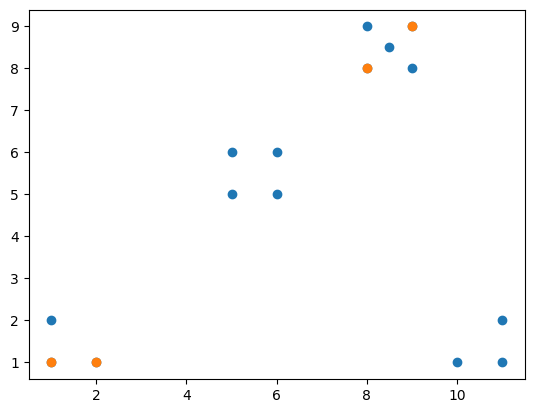

In [2166]:
centroids = jnp.asarray(list(model_fitted.init_centroids.values()))

plt.scatter(X3.T[0], X3.T[1])
plt.scatter(centroids.T[0], centroids.T[1])